In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input

classes = ["angry", "happy", "neutral", "sad"]

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True, 
    zoom_range=0.2)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"D:\code\archive\images2\images\train",
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    color_mode='rgb',
    batch_size=32,
    image_size=(48, 48),
    shuffle=True,
    seed=99
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"D:\code\archive\images2\images\validation",  # Use the same directory for validation data
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    color_mode='rgb',
    batch_size=1,
    image_size=(48, 48),
    shuffle=True,
    seed=99
)

# training_dataset = (
#     train_dataset
#     .prefetch(tf.data.AUTOTUNE)
# )
# validation_dataset = (
#     validation_dataset
#     .prefetch(tf.data.AUTOTUNE)
# )

Found 21077 files belonging to 4 classes.
Found 5140 files belonging to 4 classes.


In [35]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.optimizers import Adam,SGD
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.001))(x)
x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.001))(x)
# until here is 98% 68% 1e-5
# x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.001))(x)
# here is 77% 62% 1e-6
# x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.001))(x)
# x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.001))(x)
# x = tf.keras.layers.Dropout(0.1)(x)
# x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.001))(x)
# x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
    layer.trainable = True

loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=4, name="top_k_accuracy")]
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Increase learning rate
    loss=loss_function,
    metrics=metrics,
)

In [36]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=2e-7) 
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset, 

    batch_size=32,
    epochs=120,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/120
659/659 ━━━━━━━━━━━━━━━━━━━━ 234s 350ms/step - accuracy: 0.3242 - loss: 1.6347 - top_k_accuracy: 1.0000 - val_accuracy: 0.4967 - val_loss: 1.1525 - val_top_k_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/120
659/659 ━━━━━━━━━━━━━━━━━━━━ 235s 356ms/step - accuracy: 0.5063 - loss: 1.1494 - top_k_accuracy: 1.0000 - val_accuracy: 0.6226 - val_loss: 0.9691 - val_top_k_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/120
659/659 ━━━━━━━━━━━━━━━━━━━━ 236s 358ms/step - accuracy: 0.6307 - loss: 0.9304 - top_k_accuracy: 1.0000 - val_accuracy: 0.6516 - val_loss: 0.8764 - val_top_k_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/120
659/659 ━━━━━━━━━━━━━━━━━━━━ 229s 348ms/step - accuracy: 0.6955 - loss: 0.8000 - top_k_accuracy: 1.0000 - val_accuracy: 0.6767 - val_loss: 0.8442 - val_top_k_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/120
659/659 ━━━━━━━━━━━━━━━━━━━━ 225s 341ms/step - accuracy: 0.7399 - loss: 0.7009 - top_k_accuracy: 1.0000 - val_accuracy: 0.6951 -

In [37]:
loss, accuracy, top_k_accuracy = model.evaluate(validation_dataset)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test top_k accuracy:', top_k_accuracy)

5140/5140 ━━━━━━━━━━━━━━━━━━━━ 72s 14ms/step - accuracy: 0.6893 - loss: 0.8405 - top_k_accuracy: 1.0000
Test loss: 0.8409062027931213
Test accuracy: 0.6951361894607544
Test top_k accuracy: 1.0


In [38]:
model.save('72_accuracy_model_images.h5')

In [30]:
# from tensorflow.keras.optimizers import SGD
# # Unfreeze the top layers of the model
for layer in model.layers[-20:]:
    layer.trainable = True

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=2e-10)
model.compile(
    optimizer=Adam(learning_rate=1e-12),  
    loss=loss_function,
    metrics=metrics,
)
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training
history_fine = model.fit(
    train_dataset,
    validation_data=validation_dataset, 

    batch_size=32,
    epochs=100,
    # verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100


659/659 ━━━━━━━━━━━━━━━━━━━━ 577s 792ms/step - accuracy: 0.7633 - loss: 0.6084 - top_k_accuracy: 1.0000 - val_accuracy: 0.6932 - val_loss: 0.8380 - val_top_k_accuracy: 1.0000 - learning_rate: 1.0000e-12
Epoch 2/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 456s 692ms/step - accuracy: 0.7883 - loss: 0.6098 - top_k_accuracy: 1.0000 - val_accuracy: 0.6932 - val_loss: 0.8380 - val_top_k_accuracy: 1.0000 - learning_rate: 1.0000e-12
Epoch 3/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 452s 686ms/step - accuracy: 0.7886 - loss: 0.6087 - top_k_accuracy: 1.0000 - val_accuracy: 0.6932 - val_loss: 0.8380 - val_top_k_accuracy: 1.0000 - learning_rate: 1.0000e-12
Epoch 4/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 491s 746ms/step - accuracy: 0.7885 - loss: 0.6100 - top_k_accuracy: 1.0000 - val_accuracy: 0.6932 - val_loss: 0.8380 - val_top_k_accuracy: 1.0000 - learning_rate: 1.0000e-12
Epoch 5/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 501s 760ms/step - accuracy: 0.7893 - loss: 0.6092 - top_k_accuracy: 1.0000 - val_accuracy: 0.6932 - val_loss: 0

In [31]:
# Evaluate the model on the validation dataset
loss, accuracy, top_k_accuracy = model.evaluate(validation_dataset)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test top_k accuracy:', top_k_accuracy)

5140/5140 ━━━━━━━━━━━━━━━━━━━━ 205s 40ms/step - accuracy: 0.7039 - loss: 0.8183 - top_k_accuracy: 1.0000
Test loss: 0.8379868268966675
Test accuracy: 0.6931906342506409
Test top_k accuracy: 1.0


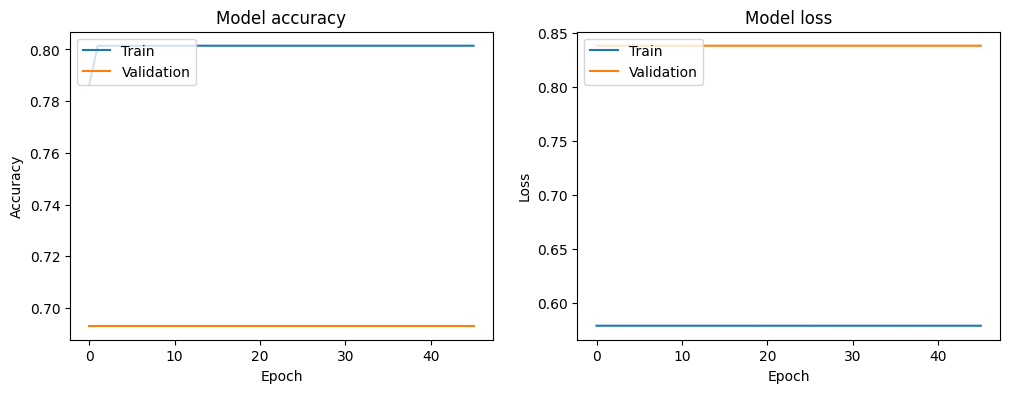

In [32]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

plot_history(history_fine)


In [33]:
# Assuming 'model' is your trained model
model.save('model_images.h5')  # You can use .h5 or no extension for SavedModel format
